In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
ALGO = "STR_PCPTRN_RE-RANKER"
cb_td, cb_vd=  "CB_" + ALGO + "_FEATURE_SEL_TD", "CB_" + ALGO + "_FEATURE_SEL_VD"
# set to be the same for now
sc_td, sc_vd = "SC_" + ALGO + "_FEATURE_SEL_TD", "SC_" + ALGO + "_FEATURE_SEL_VD"

In [3]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """
    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [4]:
client = pymongo.MongoClient()
db = client.metrics_causal_model_reranker

cb_td, cb_vd = db[cb_td], db[cb_vd]
sc_td, sc_vd = db[sc_td], db[sc_vd]

cb_td, cb_vd , sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_STR_PCPTRN_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_STR_PCPTRN_RE-RANKER_FEATURE_SEL_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_STR_PCPTRN_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_STR_PCPTRN_RE-RANKER_FEATURE_SEL_VD'))

# Query Top Features

In [5]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            #"stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

27 27 34 34


In [6]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,weighted_f1_score,hs_feats
0,5d102e8ce116f51cf6a4dc64,2019-06-23 20:59:40.503,2,"[Prob-, Above-]",0.740483,0.786858,0.699270,33.0,0.0,Above-|Prob-
1,5d102d30e116f51cf6a4dc5a,2019-06-23 20:53:52.594,2,"[Prob-, Inv-]",0.739394,0.768504,0.712409,16.0,0.0,Inv-|Prob-
2,5d103232e116f51cf6a4dc78,2019-06-23 21:15:14.591,3,"[Prob-, Above-, Propn_]",0.738169,0.787666,0.694526,37.0,0.0,Above-|Prob-|Propn_


In [7]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-06-23T20:45:54.660000000'),
 numpy.datetime64('2019-06-23T21:16:42.518000000'))

In [8]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision".split(",")
sc_cols = "feats,count,micro_f1_score,micro_recall,micro_precision,num_feats".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, cols=cols):
    df_top_individual_feats = df[(df["count"] == 1)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, False)

### Performance of Each Feature In Isolation

In [9]:
# pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])

In [10]:
import numpy as np
stemmed = True
a, b = get_top_individual_feats(cb_vd_df), get_top_individual_feats(sc_vd_df, sc_cols)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats".split(",")]

merged["num_feats_SC"] = merged["num_feats"]
del merged["num_feats"]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC
0,1,Prob-,0.737605,0.705839,0.772364,num_crels,0.806185,0.753741,0.866472,33.0
1,2,Above-,0.733841,0.685766,0.789164,Tally-,0.806185,0.753741,0.866472,24.0
2,3,Tally-,0.731736,0.690876,0.777732,Prob-,0.805816,0.751966,0.867974,12.0
3,4,num_crels,0.731349,0.708394,0.755841,Above-,0.805272,0.751458,0.867389,21.0
4,5,CREL_,0.729187,0.669708,0.800262,CREL_,0.799170,0.732691,0.878917,549.4
5,6,Diff_,0.635851,0.534672,0.784261,CChainStats-,0.758908,0.669795,0.875373,27.0
6,7,Propn_,0.633727,0.538321,0.770235,Diff_,0.672295,0.545270,0.876478,4.0
7,8,CChainStats-,0.624415,0.535766,0.748216,Propn_,0.664900,0.540959,0.862515,3.8
8,9,CChain-,0.339151,0.212774,0.835244,CChain-,0.603754,0.452701,0.906091,120.6
9,10,Inv-,0.000000,0.000000,0.000000,Inv-,0.030830,0.015724,0.784810,4.0


In [11]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", #"num_feats_CB",
                "feats_SC", "micro_f1_score_SC", "num_feats_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC,num_feats_SC
0,1,Prob-,0.738,num_crels,0.806,33.0
1,2,Above-,0.734,Tally-,0.806,24.0
2,3,Tally-,0.732,Prob-,0.806,12.0
3,4,num_crels,0.731,Above-,0.805,21.0
4,5,CREL_,0.729,CREL_,0.799,549.4
5,6,Diff_,0.636,CChainStats-,0.759,27.0
6,7,Propn_,0.634,Diff_,0.672,4.0
7,8,CChainStats-,0.624,Propn_,0.665,3.8
8,9,CChain-,0.339,CChain-,0.604,120.6
9,10,Inv-,0.000,Inv-,0.031,4.0


## Generate Rows for LaTex Table

In [12]:
def format_lbl(lbl):
    lbl = str(lbl)
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

In [13]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & Prob- & 0.738 & & num crels & 0.806\\
2 & Above- & 0.734 & & Tally- & 0.806\\
3 & Tally- & 0.732 & & Prob- & 0.806\\
4 & num crels & 0.731 & & Above- & 0.805\\
5 & CREL & 0.729 & & CREL & 0.799\\
6 & Diff & 0.636 & & CChainStats- & 0.759\\
7 & Propn & 0.634 & & Diff & 0.672\\
8 & CChainStats- & 0.624 & & Propn & 0.665\\
9 & CChain- & 0.339 & & CChain- & 0.604\\
10 & Inv- & 0.000 & & Inv- & 0.031\\


## Performance By Feature Set Size

In [14]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.737605,0.589686,0.806185,0.675332
1,2,0.740483,0.729602,0.806360,0.804896
2,3,0.738169,0.735556,0.806631,0.804774
3,4,NaN,NaN,0.806469,0.804628


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [15]:
# cols_filter = "count,new_feat,micro_f1_score,num_feats".split(",")
cols_filter = "count,new_feat,micro_f1_score".split(",")

def get_f1_by_feat_count(df):
#     df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,Prob-,0.737605,num_crels,0.806185
1,2,Above-,0.740483,Inv-,0.806360
2,3,Propn_,0.738169,Prob-,0.806631
3,4,NaN,NaN,Tally-,0.806469


In [16]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
# df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
# df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,Prob-,0.7376,num_crels,0.8062
1,2,Above-,0.7405,Inv-,0.8064
2,3,Propn_,0.7382,Prob-,0.8066
3,4,NaN,nan,Tally-,0.8065


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [17]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [18]:
df_cb = get_max_f1_by_feat_count(cb_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,1,[Prob-],0.737605,0.772364,0.705839,[num_crels],0.806185,0.866472,0.753741
1,2,"[Prob-, Above-]",0.740483,0.786858,0.699270,"[num_crels, Inv-]",0.806360,0.868560,0.752473
2,3,"[Prob-, Above-, Propn_]",0.738169,0.787666,0.694526,"[num_crels, Inv-, Prob-]",0.806631,0.868852,0.752726
3,4,NaN,NaN,NaN,NaN,"[num_crels, Inv-, Prob-, Tally-]",0.806469,0.868814,0.752473


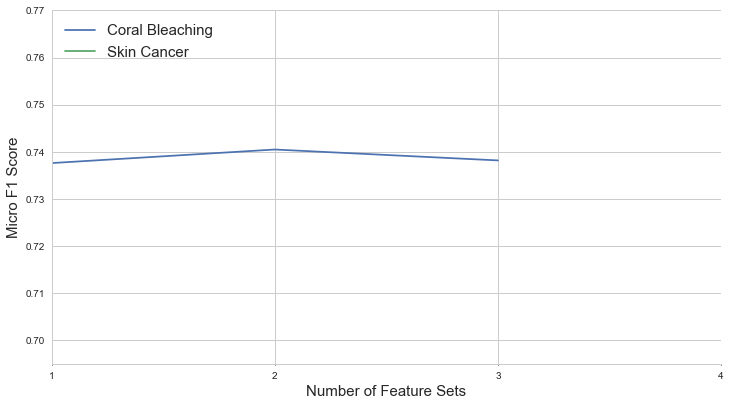

In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 4])
ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/re-ranker_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [20]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & Prob- & 0.7376 & & num crels & 0.8062\\
2 & Above- & 0.7405 & & Inv- & 0.8064\\
3 & Propn & 0.7382 & & Prob- & 0.8066\\
4 & nan & nan & & Tally- & 0.8065\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [21]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"